In [2]:
import numpy as np
import dxchange
import matplotlib.pyplot as plt
import cupy as cp
import scipy.ndimage as ndimage
import numpy as np
import sys
from matplotlib_scalebar.scalebar import ScaleBar
%matplotlib inline

astropy module not found
olefile module not found


In [3]:
n = 256  # object size in each dimension

ntheta = 360  # number of angles (rotations)
noise = 0
z1c = -12e-3
# thickness of the coded aperture
code_thickness = 1.5e-6 #in m
# feature size
ill_feature_size = 1e-6 #in m

# ntheta = int(sys.argv[1])  # number of angles (rotations)
# noise = int(sys.argv[2])#sys.argv[2]=='True'
# z1c = float(sys.argv[3])  # positions of the code and the probe for reconstruction

center = n/2 # rotation axis
theta = cp.linspace(0, np.pi, ntheta,endpoint=False).astype('float32')  # projection angles
npos = 1  # number of code positions
detector_pixelsize = 3e-6/2
energy = 33.35  # [keV] xray energy
wavelength = 1.2398419840550367e-09/energy  # [m] wave length
focusToDetectorDistance = 1.28  # [m]
sx0 = 3.7e-4
z1 = 4.584e-3-sx0# np.array([4.584e-3, 4.765e-3, 5.488e-3, 6.9895e-3])[:npos]-sx0
z1 = np.tile(z1, [npos])
z2 = focusToDetectorDistance-z1
distances = (z1*z2)/focusToDetectorDistance
magnifications = focusToDetectorDistance/z1
voxelsize = detector_pixelsize/magnifications[0]*2048/n  # object voxel size
# magnification when propagating from the probe plane to the detector
magnifications2 = z1/z1c
distances2 = (z1-z1c)/(z1c/z1)#magnifications2
# allow padding if there are shifts of the probe
pad = n//8
# sample size after demagnification
ne = n+2*pad

show = False

flg = f'{n}_{ntheta}_{npos}_{z1c}_{noise}_code'
flg1 = f'{n}_{ntheta}_{npos}_{z1c}_{noise}_code'
# print(magnifications2,norm_magnifications)
# print(distances2,distances22)
ampshifterr = 8#float(sys.argv[1])
ampcodeerr=0#float(sys.argv[2])

/data2/vnikitin/coded_apertures_new3/rec/rec_360_0.0_0.0_128.tiff


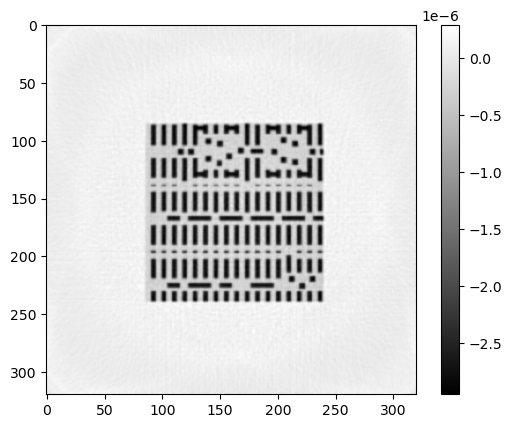

/data2/vnikitin/coded_apertures_new3/rec/rec_360_0.25_0.0_128.tiff


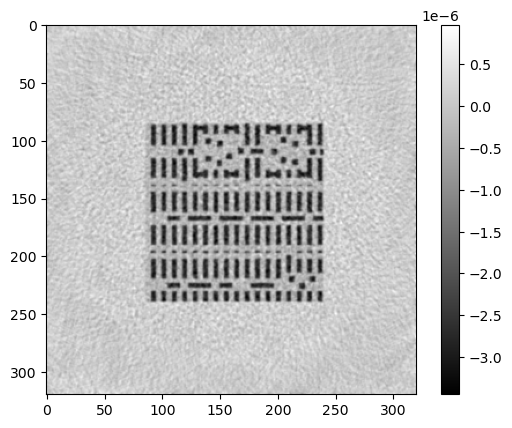

/data2/vnikitin/coded_apertures_new3/rec/rec_360_0.5_0.0_128.tiff


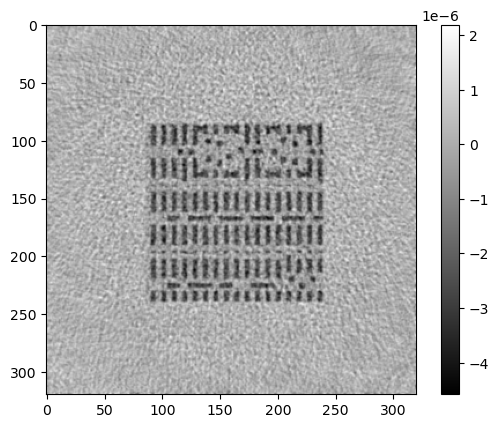

/data2/vnikitin/coded_apertures_new3/rec/rec_360_1.0_0.0_128.tiff


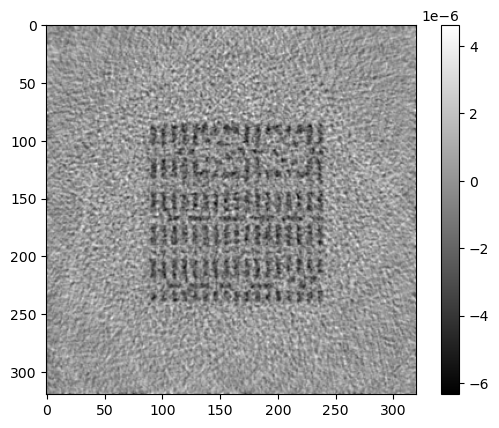

/data2/vnikitin/coded_apertures_new3/rec/rec_360_0.0_0.02_128.tiff
/data2/vnikitin/coded_apertures_new3/rec/rec_360_0.0_0.05_128.tiff
/data2/vnikitin/coded_apertures_new3/rec/rec_360_0.0_0.1_128.tiff


In [4]:

ampcodeerr = '0.0'
rec_c = {}
rec_c2 = {}
niter=128
for ampshifterr in ['0.0','0.25','0.5','1.0']:
    print(f'/data2/vnikitin/coded_apertures_new3/rec/rec_{ntheta}_{ampshifterr}_{ampcodeerr}_{niter}.tiff')
    rec_c[f'{ampshifterr}'] = dxchange.read_tiff(f'/data2/vnikitin/coded_apertures_new3/rec/rec_{ntheta}_{ampshifterr}_{ampcodeerr}_{niter}.tiff')
    rec_c[f'{ampshifterr}']=rec_c[f'{ampshifterr}']/(n*ntheta)/4/2/2*ntheta/360
    plt.imshow(rec_c[f'{ampshifterr}'][81],cmap='gray')
    plt.colorbar()
    plt.show()
ampshifterr='0.0'
for ampcodeerr in ['0.02','0.05','0.1']:
    print(f'/data2/vnikitin/coded_apertures_new3/rec/rec_{ntheta}_{ampshifterr}_{ampcodeerr}_{niter}.tiff')
    rec_c2[f'{ampcodeerr}'] = dxchange.read_tiff(f'/data2/vnikitin/coded_apertures_new3/rec/rec_{ntheta}_{ampshifterr}_{ampcodeerr}_{niter}.tiff')
    rec_c2[f'{ampcodeerr}']=rec_c2[f'{ampcodeerr}']/(n*ntheta)/4/2/2*ntheta/360
    # plt.imshow(rec_c[f'ampcodeerr'][81],cmap='gray')
    # plt.show()

In [5]:
from matplotlib_scalebar.scalebar import ScaleBar
from mpl_toolkits.axes_grid1 import make_axes_locatable
from skimage.metrics import structural_similarity as ssim
vvmin = -3e-7
vvmax = 2.4e-6
u = np.load('data/u.npy').real
u0=u[50+32,:]
# u0 = u[:,128+3]
def mshow(a,**args):
    aa=a.copy()
    aa[0,0]=vvmin
    aa[0,1]=vvmax
    plt.imshow(aa,**args)

def mshowfull(u):
    fig, ax = plt.subplots(figsize=(3,3))
    shape = u.shape
    im = ax.imshow(-u[shape[0]//2-128:shape[0]//2+128,shape[1]//2-128:shape[1]//2+128],cmap='gray',vmax=vvmax,vmin=vvmin)
    scalebar = ScaleBar(voxelsize, "m", length_fraction=0.25, font_properties={
            "family": "serif",
        },  # For more information, see the cell below
        location="lower right")
    ax.add_artist(scalebar)
    # ax.tick_params(axis='both', which='major', labelsize=11)
    
    
    uu = -u[shape[0]//2-128:shape[0]//2+128,shape[1]//2-128:shape[1]//2+128]
    ins_ax = ax.inset_axes([0.5, 0.5, .5, .5])  # [x, y, width, height] w.r.t. ax
    uu = uu[80:132,80:132]
    uu[:,:1] = vvmax
    uu[-1:,:] = vvmax
    uu[0,0] = vvmin
    
    ins_ax.imshow(uu,cmap='gray',vmax=vvmax,vmin=vvmin)
    ins_ax.axis('off')
    # ax.set_colorbar()
    a = -u[shape[0]//2-128:shape[0]//2+128,shape[1]//2-128:shape[1]//2+128]
    b = -u0[u0.shape[0]//2-128:u0.shape[0]//2+128,u0.shape[1]//2-128:u0.shape[1]//2+128]
    err = np.linalg.norm(a[c:-c,c:-c]-b[c:-c,c:-c])/np.linalg.norm(b[c:-c,c:-c])
    mssim = ssim(b[c:-c,c:-c], a[c:-c,c:-c], data_range=b.max() - b.min())
    
    if err>0.001:
        ax.text(1,228,f'error: {err:.3f}',fontsize=18,color='white')
    if err>0.001:
        ax.text(1,252,f'SSIM: {mssim:.3f}',fontsize=18,color='white')
    # else:
    #     divider = make_axes_locatable(ax)
    #     cax = divider.append_axes('right', size='5%', pad=0.1)
    #     cbar = fig.colorbar(im, cax=cax, orientation='vertical')
    #     cbar.ax.tick_params(labelsize=12)

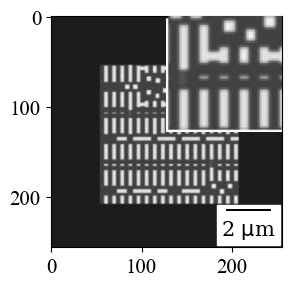

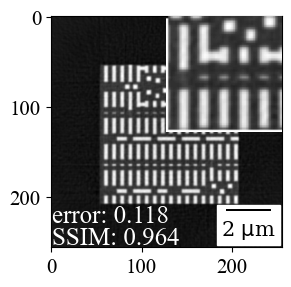

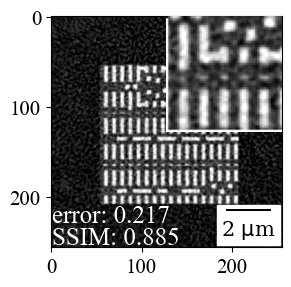

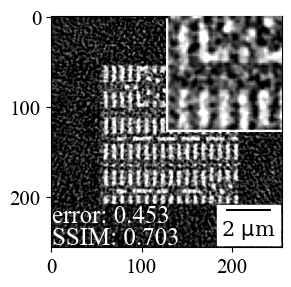

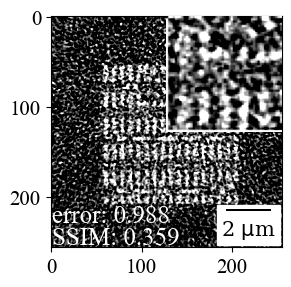

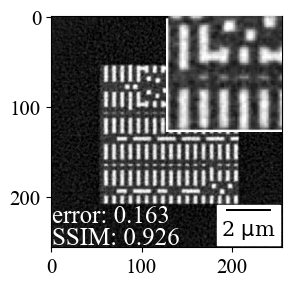

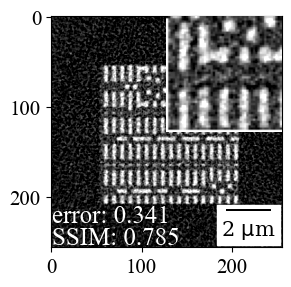

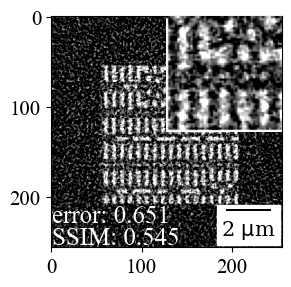

In [8]:

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error
import matplotlib
font = {'family' : 'Times New Roman', 'size'   : 15}
matplotlib.rc('font', **font)
c=64
u0 = np.load('data/u.npy').real
dxchange.write_tiff(-u0.real,'data/u',overwrite=True)
u0=u0[50+32,:]
mshowfull(u0)
plt.savefig(f'figs/u.png',dpi=300,bbox_inches='tight')

for ampshifterr in ['0.0','0.25','0.5','1.0']:
    mshowfull(rec_c[f'{ampshifterr}'][50+32])
    plt.savefig(f'figs/rec_c_{ampshifterr}.png',dpi=300,bbox_inches='tight')
for ampcodeerr in ['0.02','0.05','0.1']:
    mshowfull(rec_c2[f'{ampcodeerr}'][50+32])
    plt.savefig(f'figs/rec_c2_{ampcodeerr}.png',dpi=300,bbox_inches='tight')

In [6]:
import skimage
z1c = -0.012  # positions of the code and the probe for reconstruction
u = np.load('data/u.npy').real
noise = 1999
rec_c = {}
conv_c2 = {}
for na in [180,360,540]:
    flg = f'{n}_{na}_{1}_{z1c}_{noise}_code'
    print(f'/data2/vnikitin/coded_apertures_new3/u_{flg}/{m:03}.tiff')
    rec_c[f'{na}'] = dxchange.read_tiff(f'/data2/vnikitin/coded_apertures_new3/u_{flg}/{m:03}.tiff')
    print(rec_c[f'{na}'].shape)
    conv_c2[f'{na}'] = []#np.zeros((m-64)//32+64)#np.load(f'/data2/vnikitin/coded_apertures_new3/conv_{flg}.npy')
    # b = np.zeros([256,256],dtype='float32')
    u0=rec_c[f'{na}'] = dxchange.read_tiff(f'/data2/vnikitin/coded_apertures_new3/u_{flg}/{0:03}.tiff')
    for k in [*range(0,64),*range(64,m,32)]:
        rec_c[f'{na}'] = dxchange.read_tiff(f'/data2/vnikitin/coded_apertures_new3/u_{flg}/{k:03}.tiff')
        shape = rec_c[f'{na}'].shape
        a = -rec_c[f'{na}'][shape[0]//2-128:shape[0]//2+128,shape[1]//2-128:shape[1]//2+128]
        b = -u0[shape[0]//2-128:shape[0]//2+128,shape[1]//2-128:shape[1]//2+128]#-u[:,u.shape[1]//2+3]
        # conv_c[f'{na}'].append(skimage.metrics.peak_signal_noise_ratio(b[c:-c,c:-c], a[c:-c,c:-c],data_range=b.max()-b.min()))
        conv_c2[f'{na}'].append(np.linalg.norm(a[c:-c,c:-c]-b[c:-c,c:-c])/np.linalg.norm(b[c:-c,c:-c]))
        # conv_c[f'{na}'].append(np.linalg.norm(a[c:-c,c:-c]-b[c:-c,c:-c]))
        # b = a.copy() 
    # conv_c[f'{na}'][0] = conv_c[f'{na}'][1]

z1p = 4.21e-03
rec = {}
conv2 = {}
# flg = f'{n}_{180}_{1}_{z1p:.2e}_conv'
for na in [1,2,3]:
    flg = f'{n}_{180}_{na}_{z1p:.2e}_{noise}_conv'
    # flg = f'{n}_{180}_{na}_{z1p:.2e}_conv'
    print(f'/data2/vnikitin/coded_apertures_new3/u_{flg}/{m:03}.tiff')
    rec[f'{na}'] = dxchange.read_tiff(f'/data2/vnikitin/coded_apertures_new3/u_{flg}/{m:03}.tiff')
    conv2[f'{na}'] = []#np.zeros((m-64)//32+64)#np.load(f'/data2/vnikitin/coded_apertures_new3/conv_{flg}.npy')
    u0 = -rec[f'{na}'][shape[0]//2-128:shape[0]//2+128,shape[1]//2-128:shape[1]//2+128]
    # b = np.zeros([256,256],dtype='float32')
    for k in [*range(0,64),*range(64,m,32)]:
        rec[f'{na}'] = dxchange.read_tiff(f'/data2/vnikitin/coded_apertures_new3/u_{flg}/{k:03}.tiff')
        shape = rec[f'{na}'].shape    
        a = -rec[f'{na}'][shape[0]//2-128:shape[0]//2+128,shape[1]//2-128:shape[1]//2+128]
        #a = -rec[f'{na}'][shape[0]//2-128:shape[0]//2+128,shape[1]//2-128:shape[1]//2+128]
        b = -u0[shape[0]//2-128:shape[0]//2+128,shape[1]//2-128:shape[1]//2+128]#-u[:,u.shape[1]//2+3]
        # conv[f'{na}'].append(skimage.metrics.peak_signal_noise_ratio(b[c:-c,c:-c], a[c:-c,c:-c],data_range=b.max()-b.min()))
        conv2[f'{na}'].append(np.linalg.norm(a[c:-c,c:-c]-b[c:-c,c:-c])/np.linalg.norm(b[c:-c,c:-c]))
        # conv[f'{na}'].append(np.linalg.norm(a[c:-c,c:-c]-b[c:-c,c:-c]))
        # b = a.copy() 
    # conv[f'{na}'][0] = conv[f'{na}'][1]



NameError: name 'm' is not defined

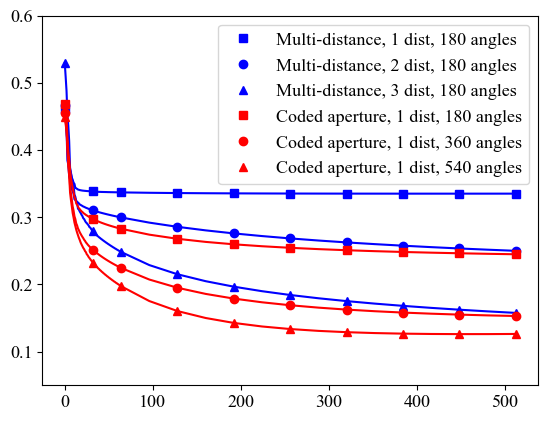

In [ ]:

import matplotlib
font = {'family' : 'Times New Roman', 'size'   : 13}
matplotlib.rc('font', **font)
x = np.array([*range(0,64),*range(64,m,32)])
plt.plot(x,conv2['1'][:],'-',color='b')
plt.plot(x[:64:32],conv2['1'][:64:32],'s',color='b')
plt.plot(x[64::2],conv2['1'][64::2],'s',color='b',label='Multi-distance, 1 dist, 180 angles')

plt.plot(x,conv2['2'][:],'-',color='b')
plt.plot(x[:64:32],conv2['2'][:64:32],'o',color='b')
plt.plot(x[64::2],conv2['2'][64::2],'o',color='b',label='Multi-distance, 2 dist, 180 angles')

plt.plot(x,conv2['3'][:],'-',color='b')
plt.plot(x[:64:32],conv2['3'][:64:32],'^',color='b')
plt.plot(x[64::2],conv2['3'][64::2],'^',color='b',label='Multi-distance, 3 dist, 180 angles')

plt.plot(x,conv_c2['180'][:],'-',color=(1, 0, 0))
plt.plot(x[:64:32],conv_c2['180'][:64:32],'s',color=(1, 0, 0))
plt.plot(x[64::2],conv_c2['180'][64::2],'s',color=(1, 0, 0),label='Coded aperture, 1 dist, 180 angles')

plt.plot(x,conv_c2['360'][:],'-',color=(1, 0, 0))
plt.plot(x[:64:32],conv_c2['360'][:64:32],'o',color=(1, 0, 0))
plt.plot(x[64::2],conv_c2['360'][64::2],'o',color=(1, 0, 0),label='Coded aperture, 1 dist, 360 angles')

plt.plot(x,conv_c2['540'][:],'-',color=(1, 0, 0))
plt.plot(x[:64:32],conv_c2['540'][:64:32],'^',color=(1, 0, 0))
plt.plot(x[64::2],conv_c2['540'][64::2],'^',color=(1, 0, 0),label='Coded aperture, 1 dist, 540 angles')

plt.ylim([0.05,0.6])

# plt.ylim([0.05,0.45])
# plt.xlim([0,65])
# plt.yscale('log')
# plt.xscale('log')
plt.legend()
plt.savefig(f'figs/noise{noise}.png',dpi=300,bbox_inches='tight')


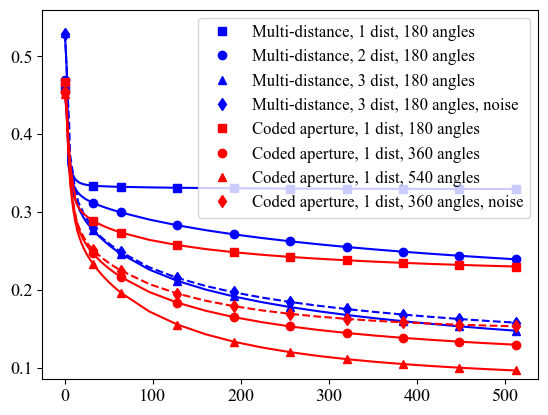

: 

In [ ]:

import matplotlib
font = {'family' : 'Times New Roman', 'size'   : 13}
matplotlib.rc('font', **font)
x = np.array([*range(0,64),*range(64,m,32)])

plt.plot(x,conv['1'][:],'-',color='b')
plt.plot(x[:64:32],conv['1'][:64:32],'s',color='b')
plt.plot(x[64::2],conv['1'][64::2],'s',color='b',label='Multi-distance, 1 dist, 180 angles')

plt.plot(x,conv['2'][:],'-',color='b')
plt.plot(x[:64:32],conv['2'][:64:32],'o',color='b')
plt.plot(x[64::2],conv['2'][64::2],'o',color='b',label='Multi-distance, 2 dist, 180 angles')

plt.plot(x,conv['3'][:],'-',color='b')
plt.plot(x[:64:32],conv['3'][:64:32],'^',color='b')
plt.plot(x[64::2],conv['3'][64::2],'^',color='b',label='Multi-distance, 3 dist, 180 angles')

plt.plot(x,conv2['3'][:],'--',color=(0, 0, 1))
plt.plot(x[:64:32],conv2['3'][:64:32],'d',color=(0, 0, 1))
plt.plot(x[64::2],conv2['3'][64::2],'d',color=(0, 0, 1),label='Multi-distance, 3 dist, 180 angles, noise')

plt.plot(x,conv_c['180'][:],'-',color=(1, 0, 0))
plt.plot(x[:64:32],conv_c['180'][:64:32],'s',color=(1, 0, 0))
plt.plot(x[64::2],conv_c['180'][64::2],'s',color=(1, 0, 0),label='Coded aperture, 1 dist, 180 angles')

plt.plot(x,conv_c['360'][:],'-',color=(1, 0, 0))
plt.plot(x[:64:32],conv_c['360'][:64:32],'o',color=(1, 0, 0))
plt.plot(x[64::2],conv_c['360'][64::2],'o',color=(1, 0, 0),label='Coded aperture, 1 dist, 360 angles')

plt.plot(x,conv_c['540'][:],'-',color=(1, 0, 0))
plt.plot(x[:64:32],conv_c['540'][:64:32],'^',color=(1, 0, 0))
plt.plot(x[64::2],conv_c['540'][64::2],'^',color=(1, 0, 0),label='Coded aperture, 1 dist, 540 angles')

plt.plot(x,conv_c2['360'][:],'--',color=(1, 0, 0))
plt.plot(x[:64:32],conv_c2['360'][:64:32],'d',color=(1, 0, 0))
plt.plot(x[64::2],conv_c2['360'][64::2],'d',color=(1, 0, 0),label='Coded aperture, 1 dist, 360 angles, noise')



plt.ylim([0.085,0.56])
# plt.xlim([0,65])
# plt.yscale('log')
# plt.xscale('log')
plt.legend(fontsize=12,loc='upper right')
plt.savefig(f'figs/noise{noise}.png',dpi=300,bbox_inches='tight')


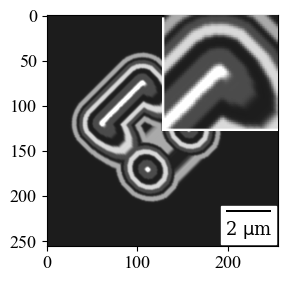

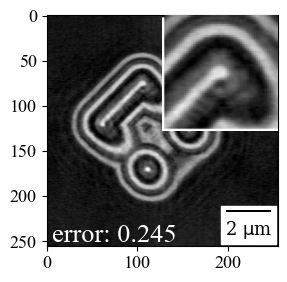

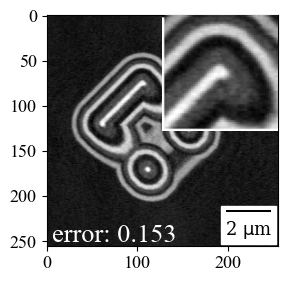

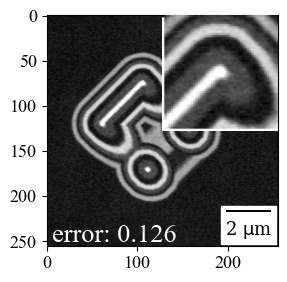

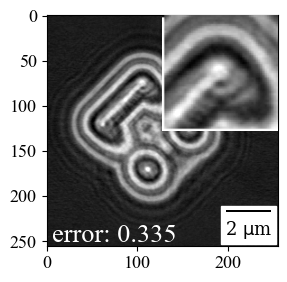

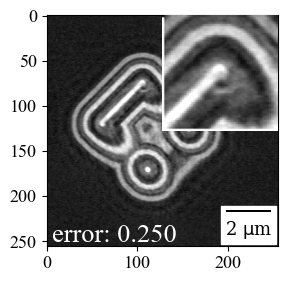

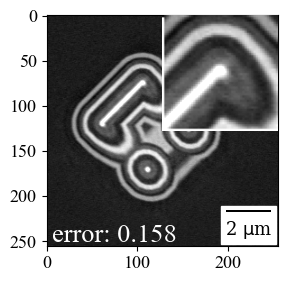

In [ ]:

from skimage.metrics import structural_similarity as ssim
from skimage.metrics import mean_squared_error

mshowfull(u[:,128+3])
plt.savefig(f'figs/u.png',dpi=300,bbox_inches='tight')

for na in [180,360,540]:
    mshowfull(rec_c[f'{na}'])
    plt.savefig(f'figs/rec_cn_{na}.png',dpi=300,bbox_inches='tight')
for na in [1,2,3]:
    mshowfull(rec[f'{na}'])
    plt.savefig(f'figs/recn_{na}.png',dpi=300,bbox_inches='tight')